In [50]:
!pip install pandas matplotlib numpy
!pip install scikit-survival

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [52]:
data = pd.read_csv("data/LengthOfStay.csv")  # Load your CSV file
X = data.drop(columns=["eid", "vdate", "discharged", "facid", "lengthofstay", "secondarydiagnosisnonicd9", "rcount"])
data_sample = data.sample(n=20000, random_state=20)

X_sample = data_sample.drop(columns=["eid", "vdate", "discharged", "facid", "lengthofstay", "secondarydiagnosisnonicd9", "rcount"])

from sksurv.util import Surv
y = Surv.from_arrays(event=[True] * len(data), time=data["lengthofstay"])

# Example of handling 'gender' with OrdinalEncoder, adjust for other columns as needed
from sklearn.preprocessing import OrdinalEncoder

X['gender'] = OrdinalEncoder().fit_transform(X[['gender']])  
X_sample['gender'] = OrdinalEncoder().fit_transform(X_sample[['gender']]) # For reduced data
y_sample = Surv.from_arrays(event=[True] * len(data_sample), time=data_sample["lengthofstay"]) # For reduced data
Xt = X  # Use X or continue with OneHotEncoder if you need further encoding

In [53]:
random_state = 20

#X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)
#print(X_train.shape)

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.25, random_state=20) # For reduced data

# Fit the Random Survival Forest on the reduced dataset

In [54]:
#rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=15, max_depth=10, n_jobs=2, random_state=random_state)
#rsf.fit(X_train, y_train)

rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=10, min_samples_leaf=15, max_depth=10, n_jobs=2, random_state=20)
rsf.fit(X_train_sample, y_train_sample) # For reduced data


RandomSurvivalForest(max_depth=10, min_samples_leaf=15, min_samples_split=10,
                     n_estimators=200, n_jobs=2, random_state=20)

In [55]:
rsf.score(X_test, y_test)

0.7339731943707901

In [56]:
X_test_sorted = X_test.sort_values(by=["gender", "glucose"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

gender  dialysisrenalendstage  asthma  irondef  pneum  \
60538     0.0                      0       0        0      0   
59079     0.0                      0       0        0      0   
47452     0.0                      0       0        0      0   
33550     1.0                      0       0        0      0   
14678     1.0                      0       0        0      0   
91549     1.0                      0       0        0      0   

       substancedependence  psychologicaldisordermajor  depress  psychother  \
60538                    0                           1        0           0   
59079                    0                           0        0           0   
47452                    0                           1        1           0   
33550                    0                           0        0           0   
14678                    0                           1        0           0   
91549                    0                           0        0           0   

       fibrosisandother  ...  hemo  hematocrit  neutrophils      sodium  \
60538                 0  ...     0       10.00        14.80  138.325911   
59079                 0  ...     0        9.50        11.20  135.431523   
47452                 0  ...     0       12.40        15.10  137.688108   
33550                 0  ...     0       12.40         8.20  133.244335   
14678                 0  ...     0       16.30         6.10  138.903540   
91549                 0  ...     0       13.55        10.85  138.190138   

          glucose  bloodureanitro  creatinine        bmi  pulse  respiration  
60538   28.537299            18.0    1.005237  29.946339     86          4.7  
59079   31.025116            12.0    1.101242  28.734724     67          6.5  
47452   39.130242             5.0    0.806633  30.105154     78          6.3  
33550  249.078219            20.0    1.185317  27.740499     88          7.4  
14678  249.982983             7.0    1.521338  30.506517     75          7.0  
91549  271.444277            12.0    1.075741  27.265048     81          8.1  

[6 rows x 21 columns]

In [57]:
pd.Series(rsf.predict(X_test_sel))

0    34.569332
1    43.011421
2    35.258942
3    38.921586
4    34.261904
5    39.950220
dtype: float64

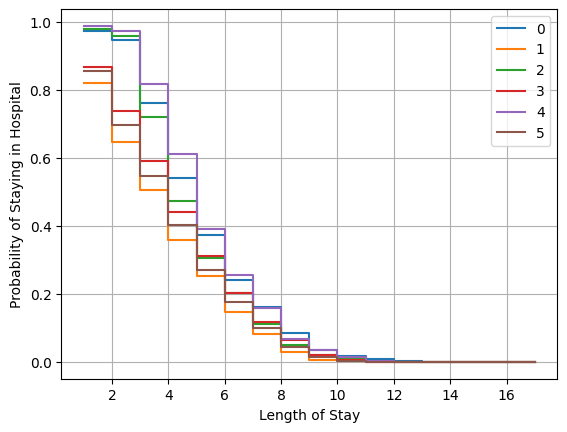

In [58]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Probability of Staying in Hospital")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

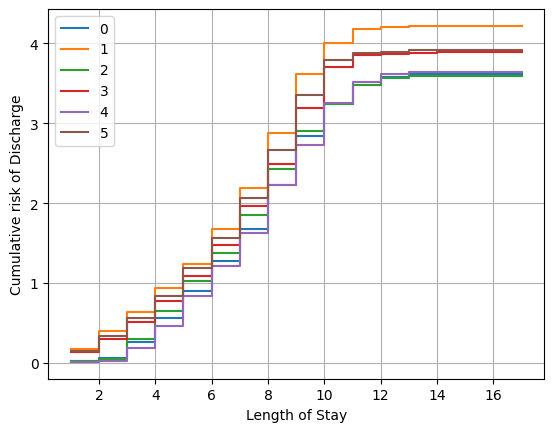

In [59]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative risk of Discharge")
plt.xlabel("Length of Stay (Days)")
plt.legend()
plt.grid(True)

In [60]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=5, random_state=random_state)

In [61]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

importances_mean  importances_std
psychologicaldisordermajor          0.049710         0.000479
hematocrit                          0.022529         0.001104
respiration                         0.018206         0.000621
irondef                             0.015083         0.000416
substancedependence                 0.012039         0.000428
hemo                                0.011902         0.000563
creatinine                          0.011436         0.000442
bmi                                 0.010762         0.000377
bloodureanitro                      0.010451         0.000768
glucose                             0.009589         0.000470
sodium                              0.009577         0.000168
pulse                               0.006616         0.000300
neutrophils                         0.004835         0.000138
asthma                              0.004023         0.000229
psychother                          0.002212         0.000505
depress                             0.002175         0.000176
pneum                               0.001384         0.000136
dialysisrenalendstage               0.001057         0.000236
malnutrition                        0.000647         0.000106
gender                              0.000215         0.000029
fibrosisandother                    0.000000         0.000000